## Single-Species Simulations 

### Three simulations
1. **Bifidobacterium alone**: growth on glucose, lactate production
2. **Eubacterium alone**: growth on glucose, butyrate production
3. **Eubacterium + Lactate**: does lactate enhance butyrate production?

In [1]:
import os
os.environ['GUROBI_COMETS_HOME'] = '/Library/gurobi1003/macos_universal2'
os.environ['COMETS_HOME'] = '/Users/fredericksenya/Documents/MATLAB/comets_macos/comets_2.12.3'
os.environ['CLASSPATH'] = f"{os.environ['COMETS_HOME']}/comets.jar:{os.environ['GUROBI_COMETS_HOME']}/lib/gurobi.jar"
os.environ['DYLD_LIBRARY_PATH'] = f"{os.environ['GUROBI_COMETS_HOME']}/lib"
os.environ['GRB_LICENSE_FILE'] = '/Library/gurobi1003/macos_universal2/gurobi.lic'

import cobra as cb
import cometspy as c
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [ ]:
# Geometry

VOL = 1e-3                         # cm³ 
SPACE_WIDTH = VOL ** (1/3)         # 0.1 cm = 1 mm
BOX_VOL_CM3 = SPACE_WIDTH ** 3     # vol
BOX_VOL_L   = BOX_VOL_CM3 * 1e-3   # 1cm^3  = 1mL = 1e-3 L

def mM_to_mmol(conc_mM):
    'concentration to mmol'
    return conc_mM * BOX_VOL_L

def mmol_to_mM(amount_mmol):
    'mmol to concentration'
    return amount_mmol / BOX_VOL_L

# Parameters
DEFAULT_VMAX = 10.0       # mmol/g/h 
DEFAULT_KM   = 5e-4       # mmol/cm3
DEFAULT_HILL  = 1
TIME_STEP  = 0.01         # h
MAX_CYCLES = 300          
LOG_RATE   = 1            

INIT_BIOMASS = 5e-7        # g  
MAX_SPACE_BIOMASS = 1e-3   # g 
MIN_SPACE_BIOMASS = 1e-14  # g

# concentrations 
GLC_CONC_mM  = 10.0      # glucose(millimolar)
NH4_CONC_mM  = 5.0       # ammonium
ION_CONC_mM  = 5.0       # major ions
AA_CONC_mM   = 2.0       # amino acids
TRACE_CONC_mM = 0.1      # trace metals & vitamins
WATER_AMOUNT  = 1e-4     # mmol 

# media
water_proton_ids = {'h2o[e]'}
major_ion_ids    = {'pi[e]', 'so4[e]', 'k[e]', 'cl[e]', 'mg2[e]', 'ca2[e]'}
trace_metal_ids  = {'fe2[e]', 'fe3[e]', 'zn2[e]', 'cu2[e]', 'mn2[e]', 'cobalt2[e]', 'cd2[e]'}
vitamin_ids      = {'ribflv[e]', 'pnto_R[e]', 'nac[e]', 'hxan[e]'}
aa_ids           = {'ala_L[e]', 'asn_L[e]', 'his_L[e]', 'leu_L[e]', 'lys_L[e]',
                    'met_L[e]', 'glycys[e]', 'glyglu[e]'}

# Combined set
background_met_ids = water_proton_ids | major_ion_ids | trace_metal_ids | vitamin_ids | aa_ids | {'nh4[e]'}


def classify_and_set_media(layout, all_ex_mets):
    for met in all_ex_mets:
        layout.set_specific_metabolite(met, 0.0)
        layout.set_specific_refresh(met, 0.0)

    for met in all_ex_mets:
        if met in water_proton_ids:
            layout.set_specific_metabolite(met, WATER_AMOUNT)
            layout.set_specific_static(met, WATER_AMOUNT)
        elif met in major_ion_ids:
            layout.set_specific_metabolite(met, mM_to_mmol(ION_CONC_mM))
            layout.set_specific_static(met, mM_to_mmol(ION_CONC_mM))
        elif met in trace_metal_ids:
            layout.set_specific_metabolite(met, mM_to_mmol(TRACE_CONC_mM))
            layout.set_specific_static(met, mM_to_mmol(TRACE_CONC_mM))
        elif met in vitamin_ids:
            layout.set_specific_metabolite(met, mM_to_mmol(TRACE_CONC_mM))
            layout.set_specific_static(met, mM_to_mmol(TRACE_CONC_mM))
        elif met in aa_ids:
            layout.set_specific_metabolite(met, mM_to_mmol(AA_CONC_mM))
            layout.set_specific_static(met, mM_to_mmol(AA_CONC_mM))
        elif met == 'nh4[e]':
            layout.set_specific_metabolite(met, mM_to_mmol(NH4_CONC_mM))
            layout.set_specific_static(met, mM_to_mmol(NH4_CONC_mM))


def make_params():
    params = c.params()
    params.set_param('spaceWidth',       SPACE_WIDTH)
    params.set_param('defaultVmax',      DEFAULT_VMAX)
    params.set_param('defaultKm',        DEFAULT_KM)
    params.set_param('defaultHill',      DEFAULT_HILL)
    params.set_param('exchangestyle',    'Monod Style')
    params.set_param('timeStep',         TIME_STEP)
    params.set_param('maxCycles',        MAX_CYCLES)
    params.set_param('maxSpaceBiomass',  MAX_SPACE_BIOMASS)
    params.set_param('minSpaceBiomass',  MIN_SPACE_BIOMASS)
    params.set_param('writeMediaLog',    True)
    params.set_param('MediaLogRate',     LOG_RATE)
    params.set_param('writeFluxLog',     True)
    params.set_param('FluxLogRate',      LOG_RATE)
    params.set_param('writeBiomassLog',  True)
    params.set_param('BiomassLogRate',   LOG_RATE)
    return params


def clean_non_ex(comets_model):
    'COMETS bug fix'
    ex_mask = comets_model.reactions['EXCH'].isin([True, 'True'])
    for name in comets_model.reactions.loc[ex_mask, 'REACTION_NAMES']:
        name = str(name)
        if not name.startswith('EX_'):
            comets_model.reactions.loc[
                comets_model.reactions['REACTION_NAMES'] == name, 'EXCH'] = False
            comets_model.reactions.loc[
                comets_model.reactions['REACTION_NAMES'] == name, 'EXCH_IND'] = 0

print(f'Glucose:     {GLC_CONC_mM} mM  → {mM_to_mmol(GLC_CONC_mM):.2e} mmol')

Glucose:     10.0 mM  → 1.00e-05 mmol



# *Bifido in mucus enviroment*

In [3]:

model_bif = cb.io.load_matlab_model('Bifidobacterium_longum_infantis_ATCC_15697.mat')
model_bif.id = 'Bifido'

for rxn in model_bif.exchanges:
    rxn.lower_bound = 0.0
    rxn.upper_bound = 1000.0

met_to_ex_bif = {met.id: rxn.id for rxn in model_bif.exchanges
                 for met in rxn.metabolites if met.compartment == 'e'}

all_ex_mets_bif = set(met_to_ex_bif.keys())
print(f'Exchanges: {len(all_ex_mets_bif)}')


# FBA 
with model_bif as m:
    for rxn in m.exchanges:
        rxn.lower_bound = 0.0
    for met_id in background_met_ids & all_ex_mets_bif:
        ex_id = met_to_ex_bif.get(met_id)
        if ex_id:
            m.reactions.get_by_id(ex_id).lower_bound = -1000.0
    ex_glc = met_to_ex_bif.get('glc_D[e]')
    if ex_glc:
        m.reactions.get_by_id(ex_glc).lower_bound = -GLC_CONC_mM
    sol = m.optimize()
    print(f'FBA growth rate: {sol.objective_value:.4f} 1/h')


# comets model
comets_bif = c.model(model_bif)
comets_bif.open_exchanges()
clean_non_ex(comets_bif)
comets_bif.initial_pop = [0, 0, INIT_BIOMASS]

# layout
layout = c.layout([comets_bif])
layout.grid = [1, 1]

classify_and_set_media(layout, all_ex_mets_bif)

# Glucose
layout.set_specific_metabolite('glc_D[e]', mM_to_mmol(GLC_CONC_mM))
layout.set_specific_refresh('glc_D[e]', 0.0)

# Run
params = make_params()
sim_bif = c.comets(layout, params)
sim_bif.run()

No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


Exchanges: 162
FBA growth rate: 0.1335 1/h

Running COMETS simulation ...

Debug Here ...
Done!


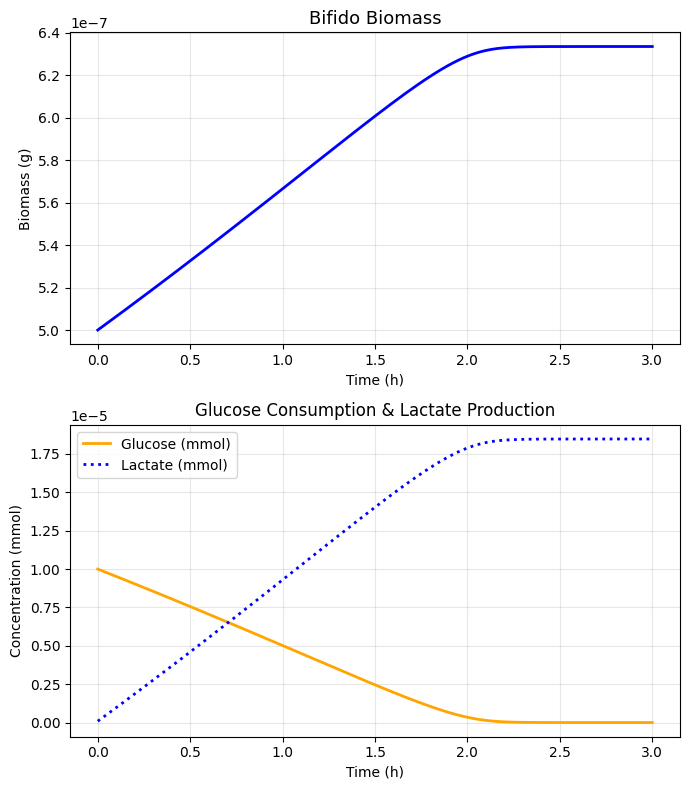

In [4]:
t_array = np.arange(len(sim_bif.total_biomass)) * TIME_STEP

fig, axs = plt.subplots(2, 1, figsize=(7, 8))

# Biomass
biomass = sim_bif.total_biomass['Bifido'].values
axs[0].plot(t_array, biomass, 'b-', lw=2)
axs[0].set_xlabel('Time (h)'); axs[0].set_ylabel('Biomass (g)')
axs[0].set_title('Bifido Biomass', fontsize=13)
axs[0].grid(alpha=0.3)

# Glucose & Lactate
md = sim_bif.media
glc_data = md.loc[md['metabolite'] == 'glc_D[e]', 'conc_mmol'].values
lac_data = md.loc[md['metabolite'] == 'lac_L[e]', 'conc_mmol'].values
#conc_glc = glc_data / BOX_VOL_L
#conc_lac = lac_data / BOX_VOL_L

t_met = t_array[:len(glc_data)]
axs[1].plot(t_met, glc_data, 'orange', lw=2, label='Glucose (mmol)')
if len(lac_data) > 0:
    axs[1].plot(t_array[:len(lac_data)], lac_data, 'b:', lw=2, label='Lactate (mmol)')
axs[1].set_xlabel('Time (h)'); axs[1].set_ylabel('Concentration (mmol)')
axs[1].set_title('Glucose Consumption & Lactate Production')
axs[1].legend(); axs[1].grid(alpha=0.3)

fig.tight_layout()
plt.show()

Tracked metabolites: 31


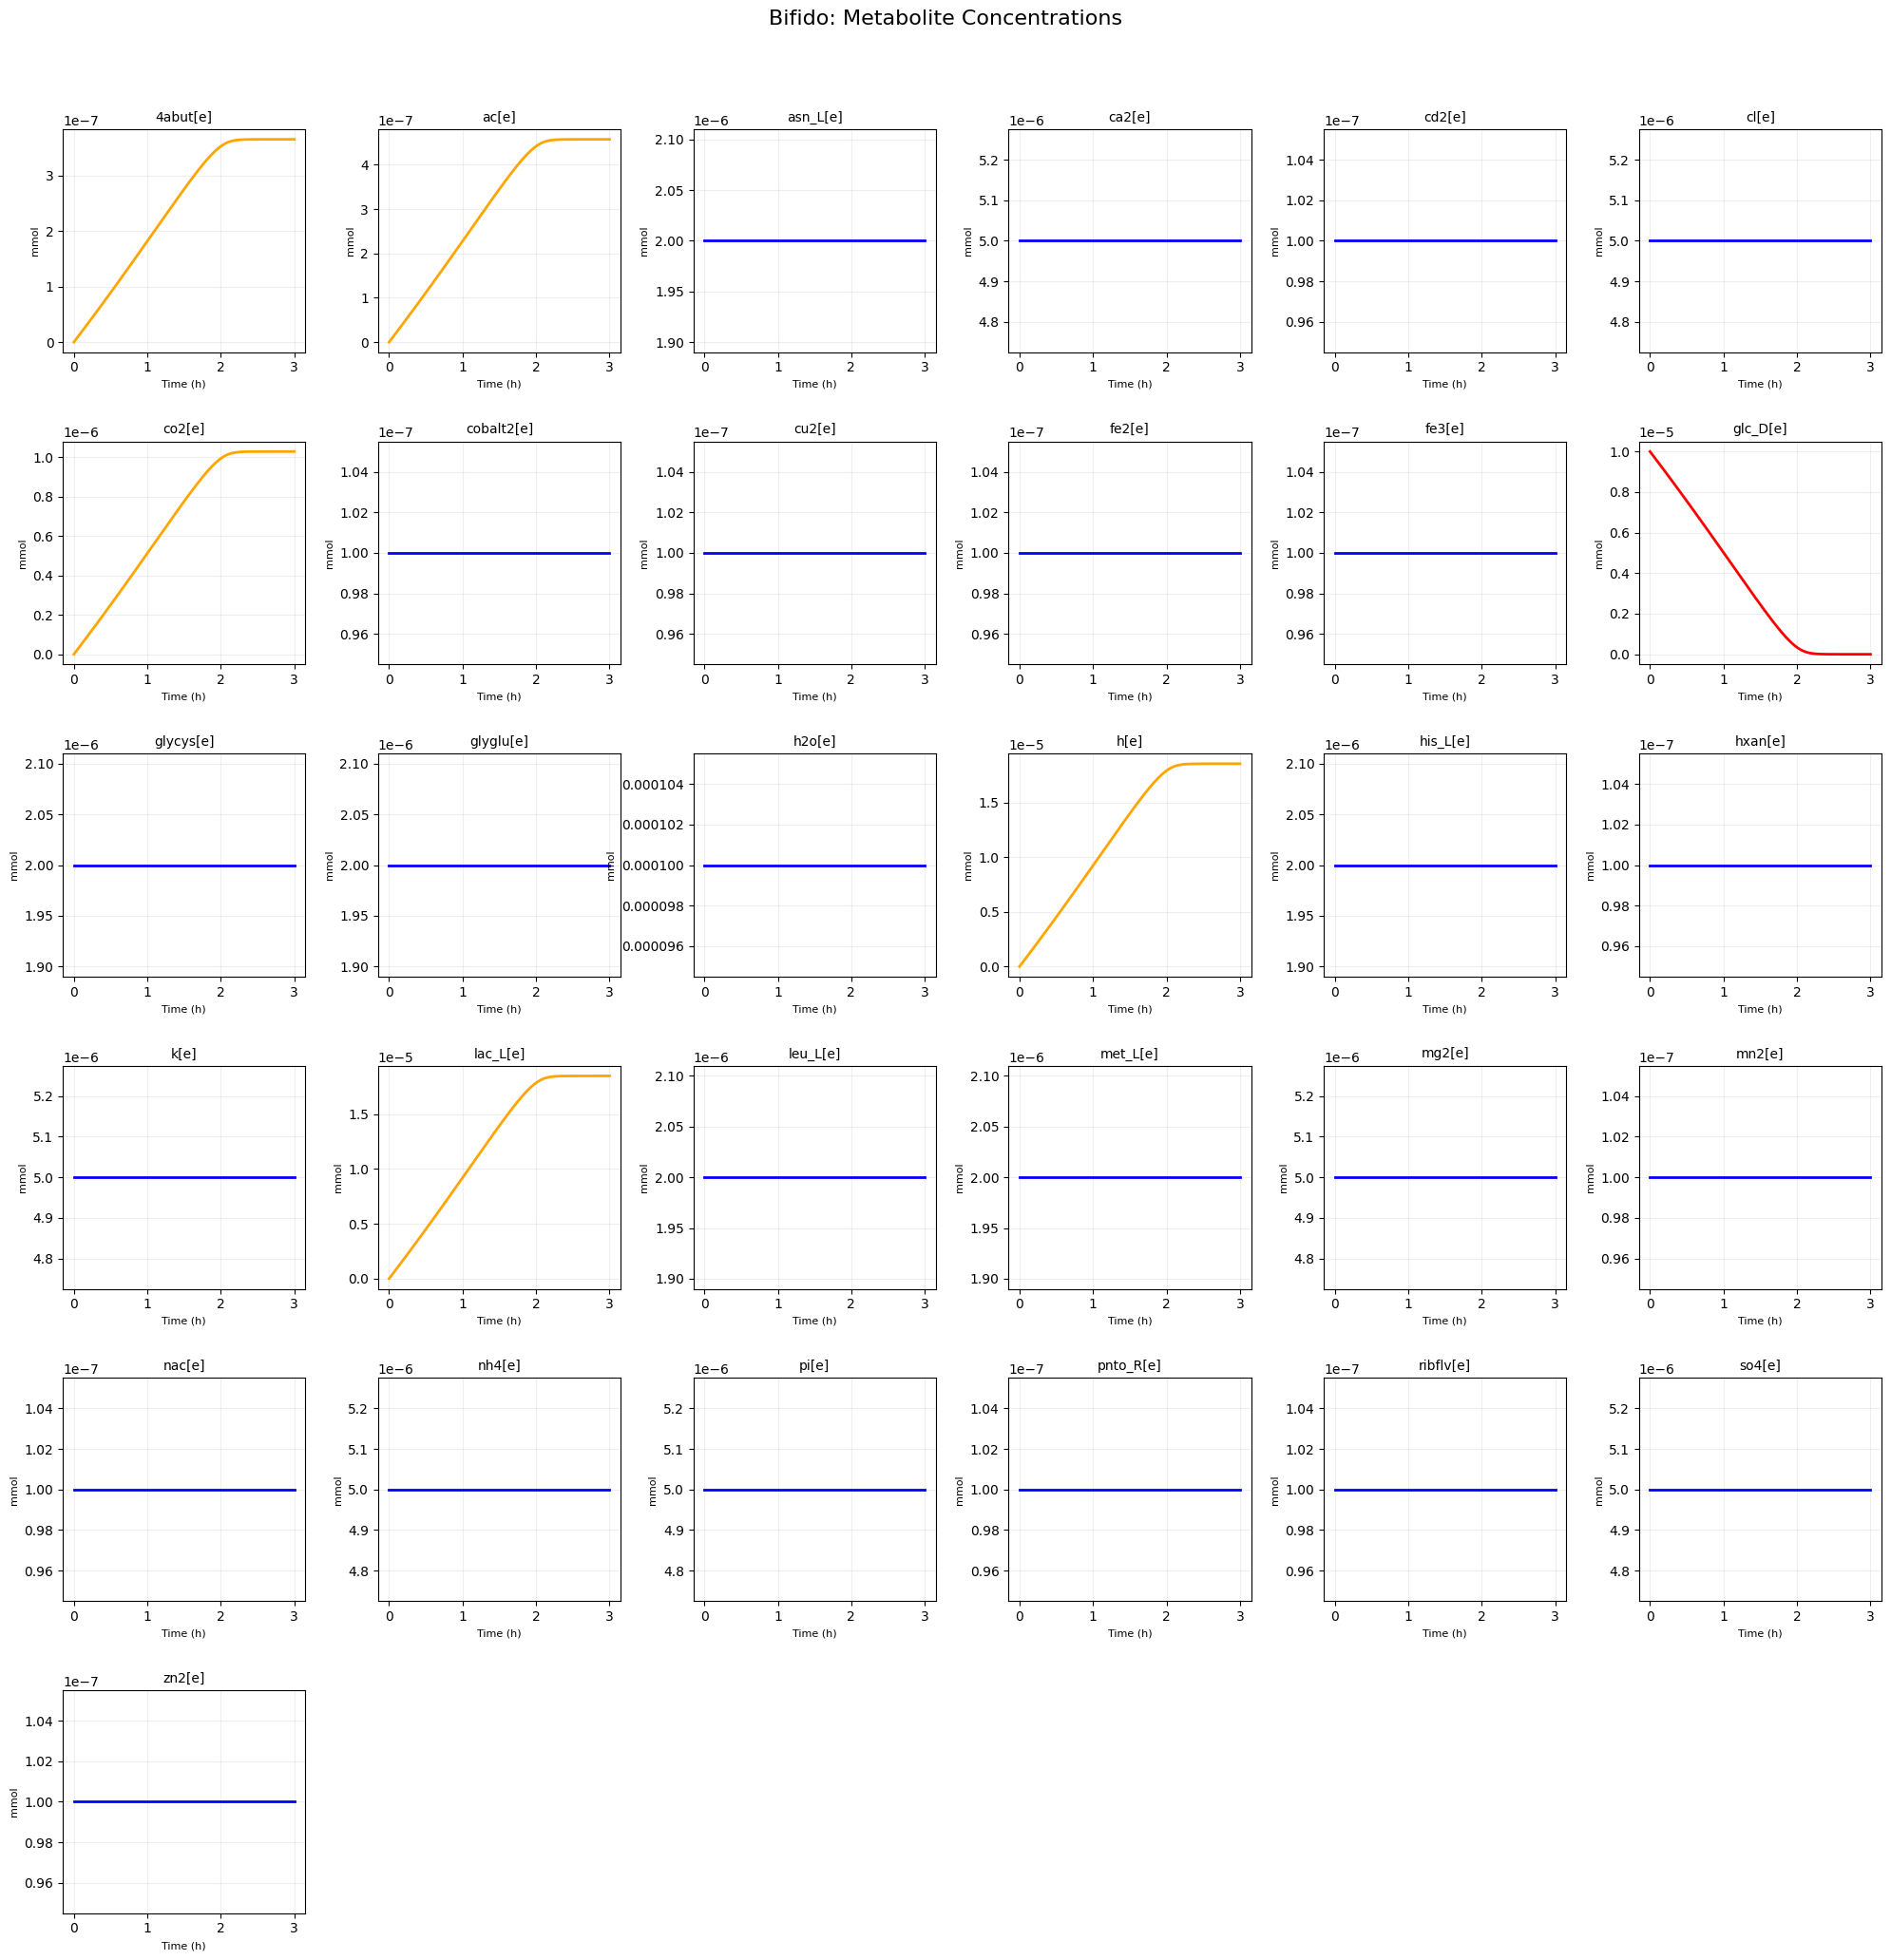

In [5]:
# metabolite concentrations over time 
media_piv = sim_bif.media.pivot(index='cycle', columns='metabolite', values='conc_mmol')
media_piv.fillna(0, inplace=True)
conc_df = media_piv.copy()

selected_mets = sorted([m for m in conc_df.columns if 'biomass' not in m.lower()])
print(f'Tracked metabolites: {len(selected_mets)}')

cols = 6
rows = math.ceil(len(selected_mets) / cols)
fig2 = plt.figure(figsize=(20, 3.5 * rows))
fig2.suptitle('Bifido: Metabolite Concentrations',
      fontsize=16, y=0.98)

time_conc = conc_df.index * TIME_STEP

for i, met in enumerate(selected_mets):
    ax = fig2.add_subplot(rows, cols, i + 1)
    conc = conc_df[met]   #conc_df[met] / BOX_VOL_L  convert to mM

    if len(conc) > 0 and conc.iloc[0] > 0 and conc.iloc[-1] < conc.iloc[0] * 0.01:
        line_color = 'red'
    elif len(conc) > 0 and conc.iloc[0] == 0 and conc.iloc[-1] > 0:
        line_color = 'orange'
    else:
        line_color = 'blue'

    ax.plot(time_conc, conc, color=line_color, linewidth=2)
    ax.set_xlabel('Time (h)', fontsize=8)
    ax.set_ylabel('mmol', fontsize=8)
    ax.set_title(met, fontsize=10)
    ax.grid(alpha=0.2)

plt.tight_layout(rect=[0, 0, 1, 0.96])
fig2.subplots_adjust(top=0.92, hspace=0.4, wspace=0.3)
plt.show()

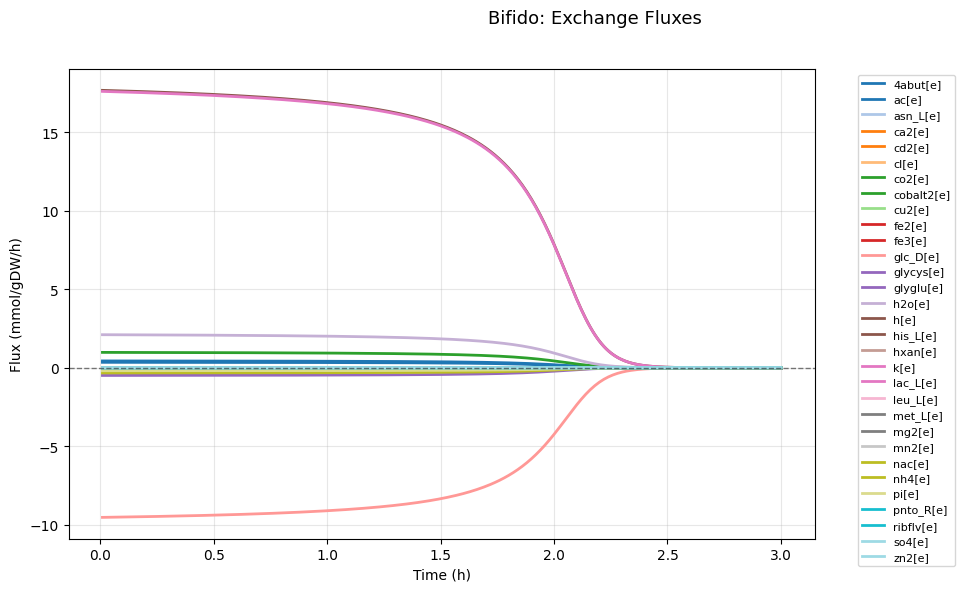

In [6]:
#Exchange flux 
selected_flux_mets = [m for m in selected_mets if m in media_piv.columns]

fig3, ax = plt.subplots(figsize=(12, 6))
fig3.suptitle('Bifido: Exchange Fluxes',
              fontsize=13, y=0.98)

time_flux = sim_bif.fluxes.iloc[:, 0] * TIME_STEP
colors = plt.cm.tab20(np.linspace(0, 1, len(selected_flux_mets)))

for i, met in enumerate(sorted(selected_flux_mets)):
    rxn_id = 'EX_' + met.replace('[e]', '(e)')
    idx = comets_bif.reactions[comets_bif.reactions['REACTION_NAMES'] == rxn_id].index
    if len(idx) == 0:
        continue
    col = 4 + idx[0]
    if col < sim_bif.fluxes.shape[1]:
        flux = sim_bif.fluxes.iloc[:, col]
        ax.plot(time_flux, flux, color=colors[i], linewidth=2, label=met)

ax.axhline(y=0, color='k', ls='--', lw=1, alpha=0.5)
ax.set_xlabel('Time (h)'); ax.set_ylabel('Flux (mmol/gDW/h)')
ax.grid(alpha=0.3)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, ncol=1)
plt.tight_layout(rect=[0, 0, 0.82, 0.96])
plt.show()

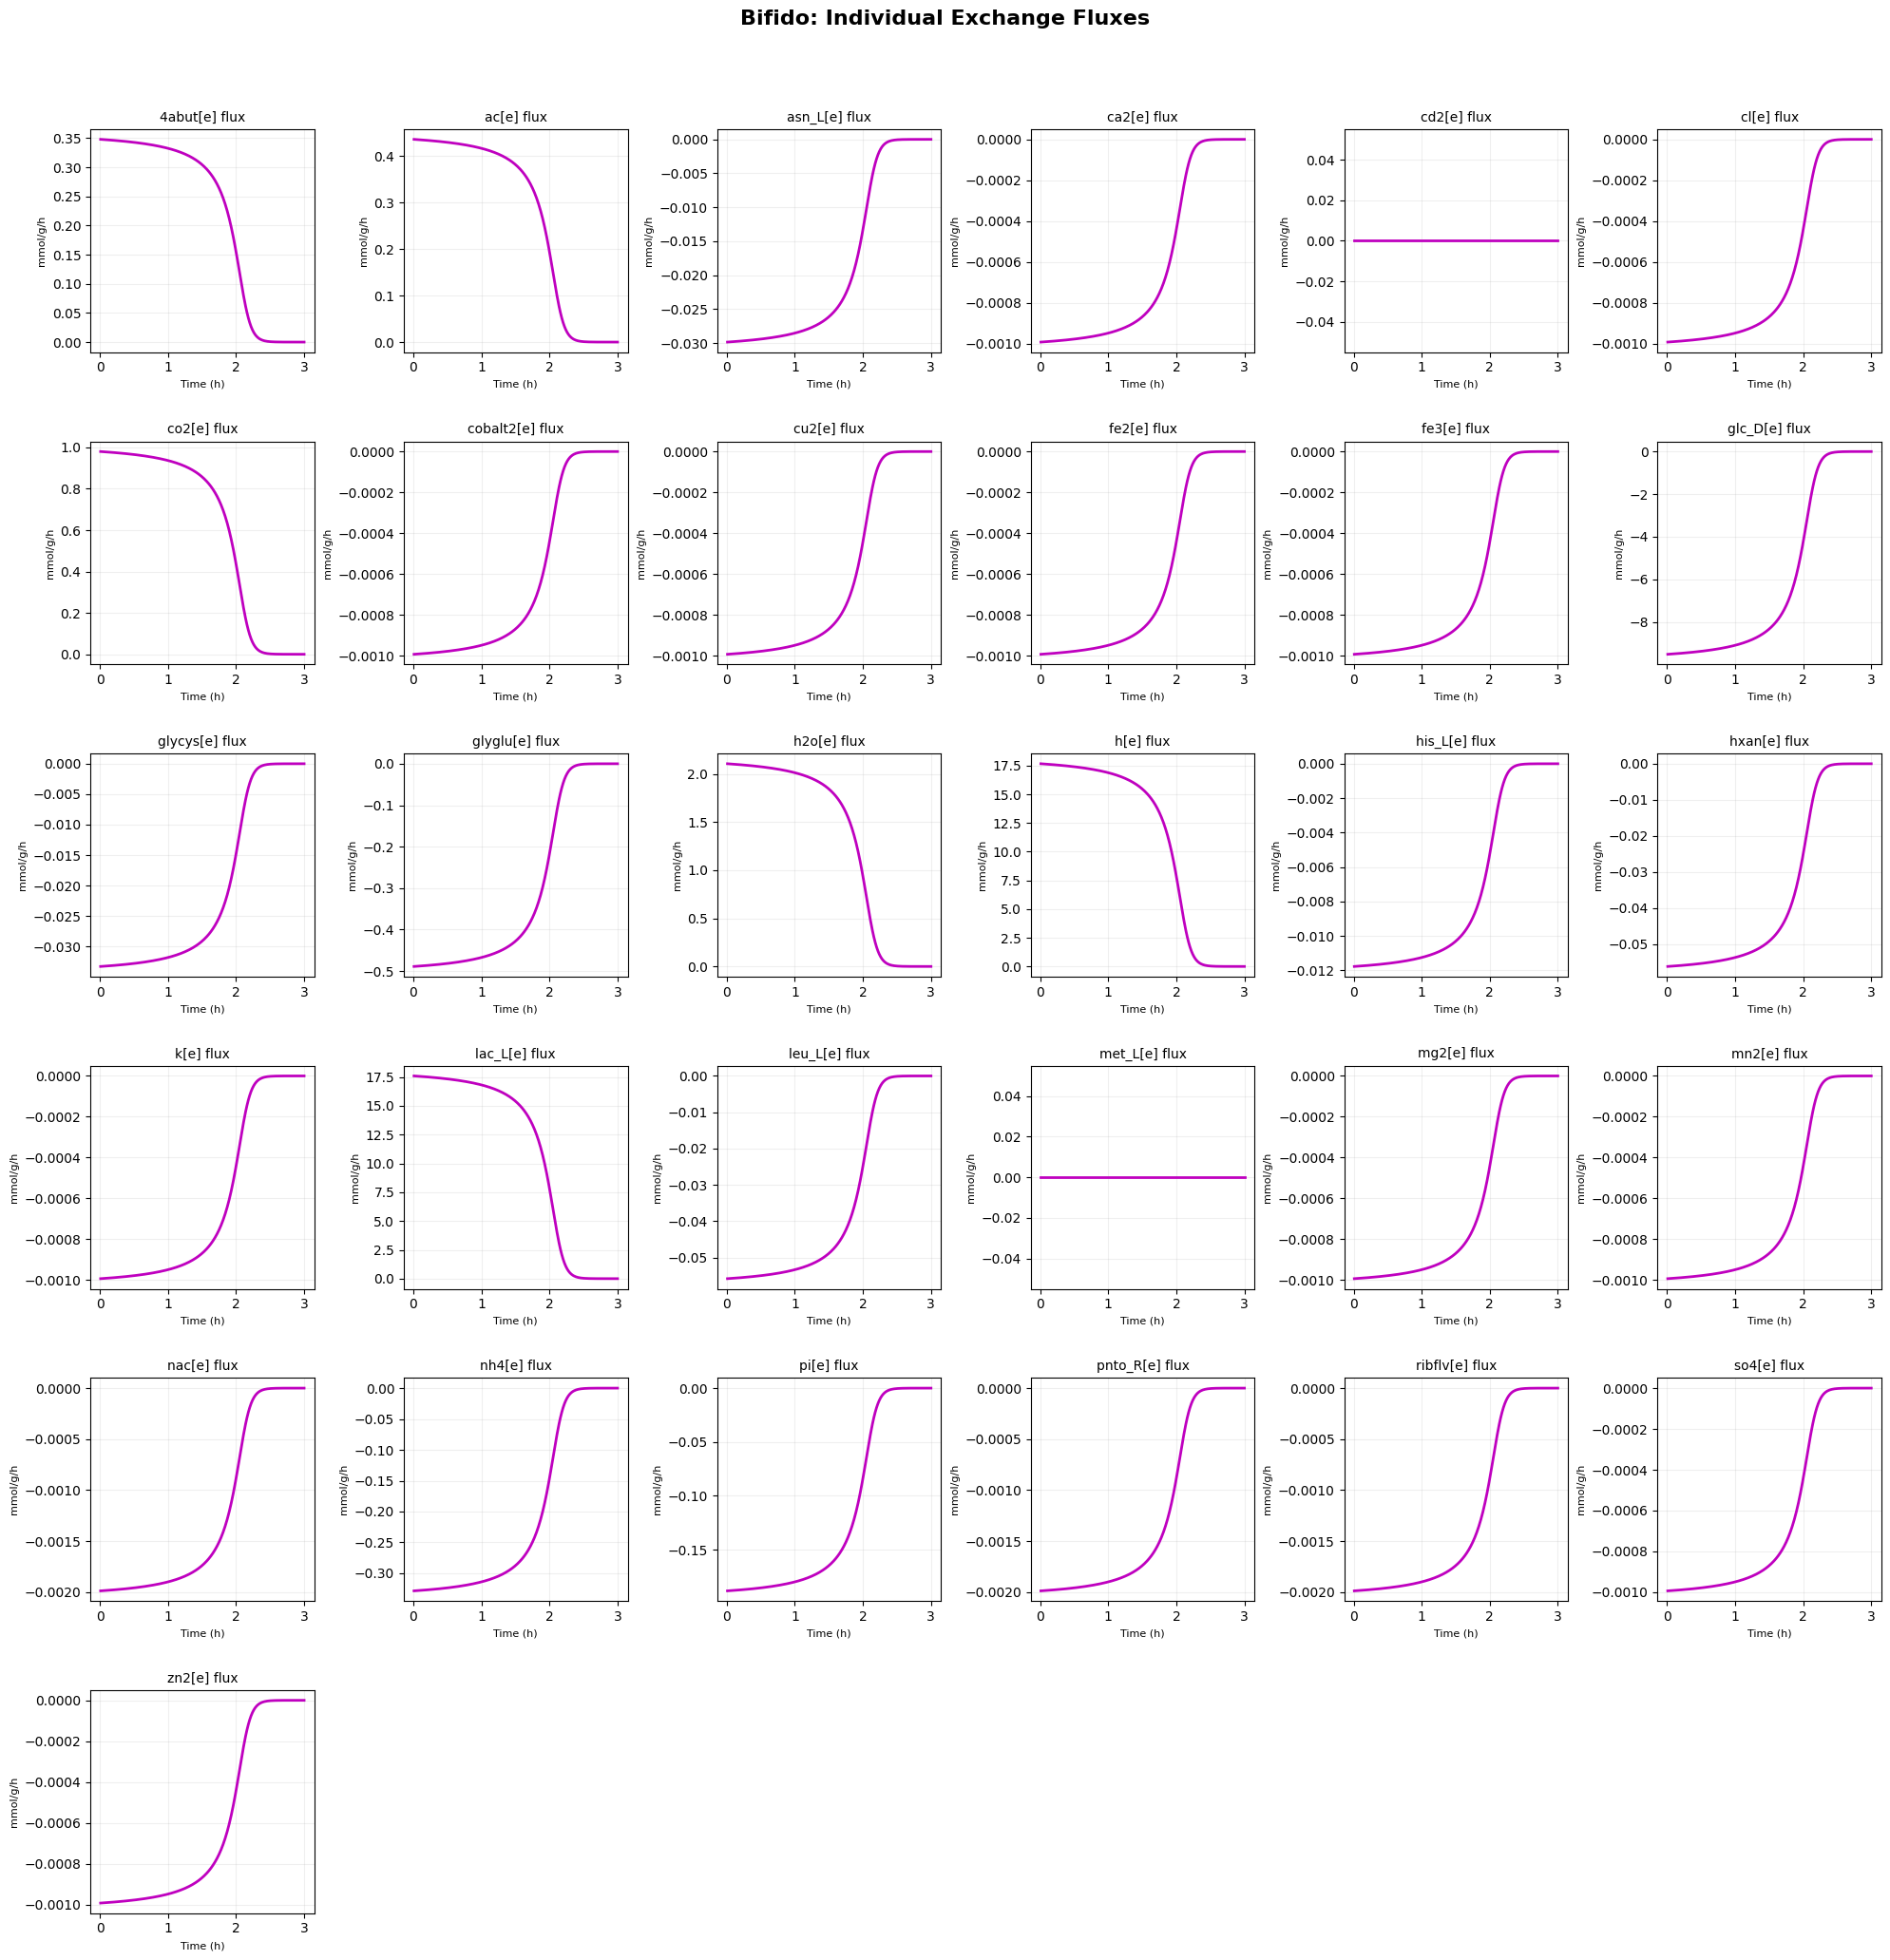

In [7]:
# Individual flux panels 
num_flux = len(selected_flux_mets)
rows_f = math.ceil(num_flux / cols)
fig4 = plt.figure(figsize=(20, 3.5 * rows_f))
fig4.suptitle('Bifido: Individual Exchange Fluxes', fontsize=16, fontweight='bold', y=0.98)

for i, met in enumerate(sorted(selected_flux_mets)):
    rxn_id = 'EX_' + met.replace('[e]', '(e)')
    idx = comets_bif.reactions[comets_bif.reactions['REACTION_NAMES'] == rxn_id].index
    if len(idx) == 0:
        continue
    col_idx = 4 + idx[0]
    if col_idx >= sim_bif.fluxes.shape[1]:
        continue
    flux = sim_bif.fluxes.iloc[:, col_idx]
    ax = fig4.add_subplot(rows_f, cols, i + 1)
    ax.plot(time_flux, flux, color='m', linewidth=2)
    ax.set_title(met + ' flux', fontsize=10)
    ax.set_xlabel('Time (h)', fontsize=8)
    ax.set_ylabel('mmol/g/h', fontsize=8)
    ax.grid(alpha=0.2)

plt.tight_layout(rect=[0, 0, 1, 0.96])
fig4.subplots_adjust(top=0.92, hspace=0.4, wspace=0.4)
plt.show()


# Eubacterium in mucus enviroment


In [8]:
model_eub = cb.io.load_matlab_model('Eubacterium_hallii_DSM_3353.mat')
model_eub.id = 'Eubacterium'

for rxn in model_eub.exchanges:
    rxn.lower_bound = 0.0
    rxn.upper_bound = 1000.0

met_to_ex_eub = {met.id: rxn.id for rxn in model_eub.exchanges
                 for met in rxn.metabolites if met.compartment == 'e'}
all_ex_mets_eub = set(met_to_ex_eub.keys())
print(f'Exchanges: {len(all_ex_mets_eub)}')

# FBA check
with model_eub as m:
    for rxn in m.exchanges:
        rxn.lower_bound = 0.0
    for met_id in background_met_ids & all_ex_mets_eub:
        ex_id = met_to_ex_eub.get(met_id)
        if ex_id:
            m.reactions.get_by_id(ex_id).lower_bound = -1000.0
    ex_glc = met_to_ex_eub.get('glc_D[e]')
    if ex_glc:
        m.reactions.get_by_id(ex_glc).lower_bound = -GLC_CONC_mM
    sol = m.optimize()
    print(f'FBA growth rate: {sol.objective_value:.4f} 1/h')

# COMETS model
comets_eub = c.model(model_eub)
comets_eub.open_exchanges()
clean_non_ex(comets_eub)
comets_eub.initial_pop = [0, 0, INIT_BIOMASS]

# layout
layout2 = c.layout([comets_eub])
layout2.grid = [1, 1]
classify_and_set_media(layout2, all_ex_mets_eub)
layout2.set_specific_metabolite('glc_D[e]', mM_to_mmol(GLC_CONC_mM))
layout2.set_specific_refresh('glc_D[e]', 0.0)

# Run
params2 = make_params()
sim_eub = c.comets(layout2, params2)
sim_eub.run()

No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


Exchanges: 119
FBA growth rate: 0.4148 1/h

Running COMETS simulation ...

Debug Here ...
Done!


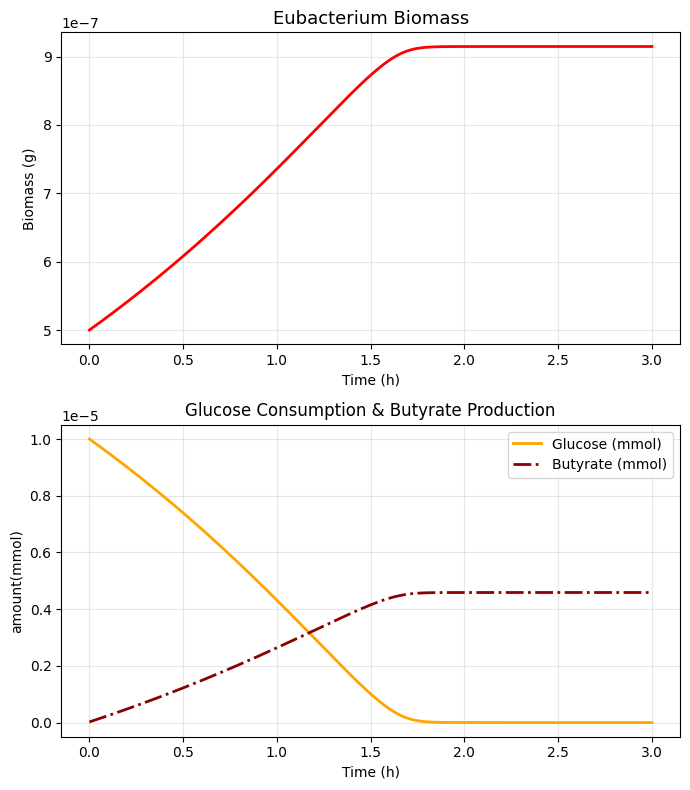

In [17]:
t_arr2 = np.arange(len(sim_eub.total_biomass)) * TIME_STEP

fig, axs = plt.subplots(2, 1, figsize=(7, 8))

biomass2 = sim_eub.total_biomass['Eubacterium'].values
axs[0].plot(t_arr2, biomass2, 'r-', lw=2)
axs[0].set_xlabel('Time (h)'); axs[0].set_ylabel('Biomass (g)')
axs[0].set_title('Eubacterium Biomass', fontsize=13)
axs[0].grid(alpha=0.3)

md2 = sim_eub.media
glc2 = md2.loc[md2['metabolite'] == 'glc_D[e]', 'conc_mmol'].values
but2 = md2.loc[md2['metabolite'] == 'but[e]', 'conc_mmol'].values
#conc_glc = glc2 / BOX_VOL_L
#conc_but = but2 / BOX_VOL_L

axs[1].plot(t_arr2[:len(glc2)], glc2, 'orange', lw=2, label='Glucose (mmol)')
if len(but2) > 0:
    axs[1].plot(t_arr2[:len(but2)], but2, 'darkred', lw=2, ls='-.', label='Butyrate (mmol)')
axs[1].set_xlabel('Time (h)'); axs[1].set_ylabel('amount(mmol)')
axs[1].set_title('Glucose Consumption & Butyrate Production')
axs[1].legend(); axs[1].grid(alpha=0.3)

fig.tight_layout()
plt.show()

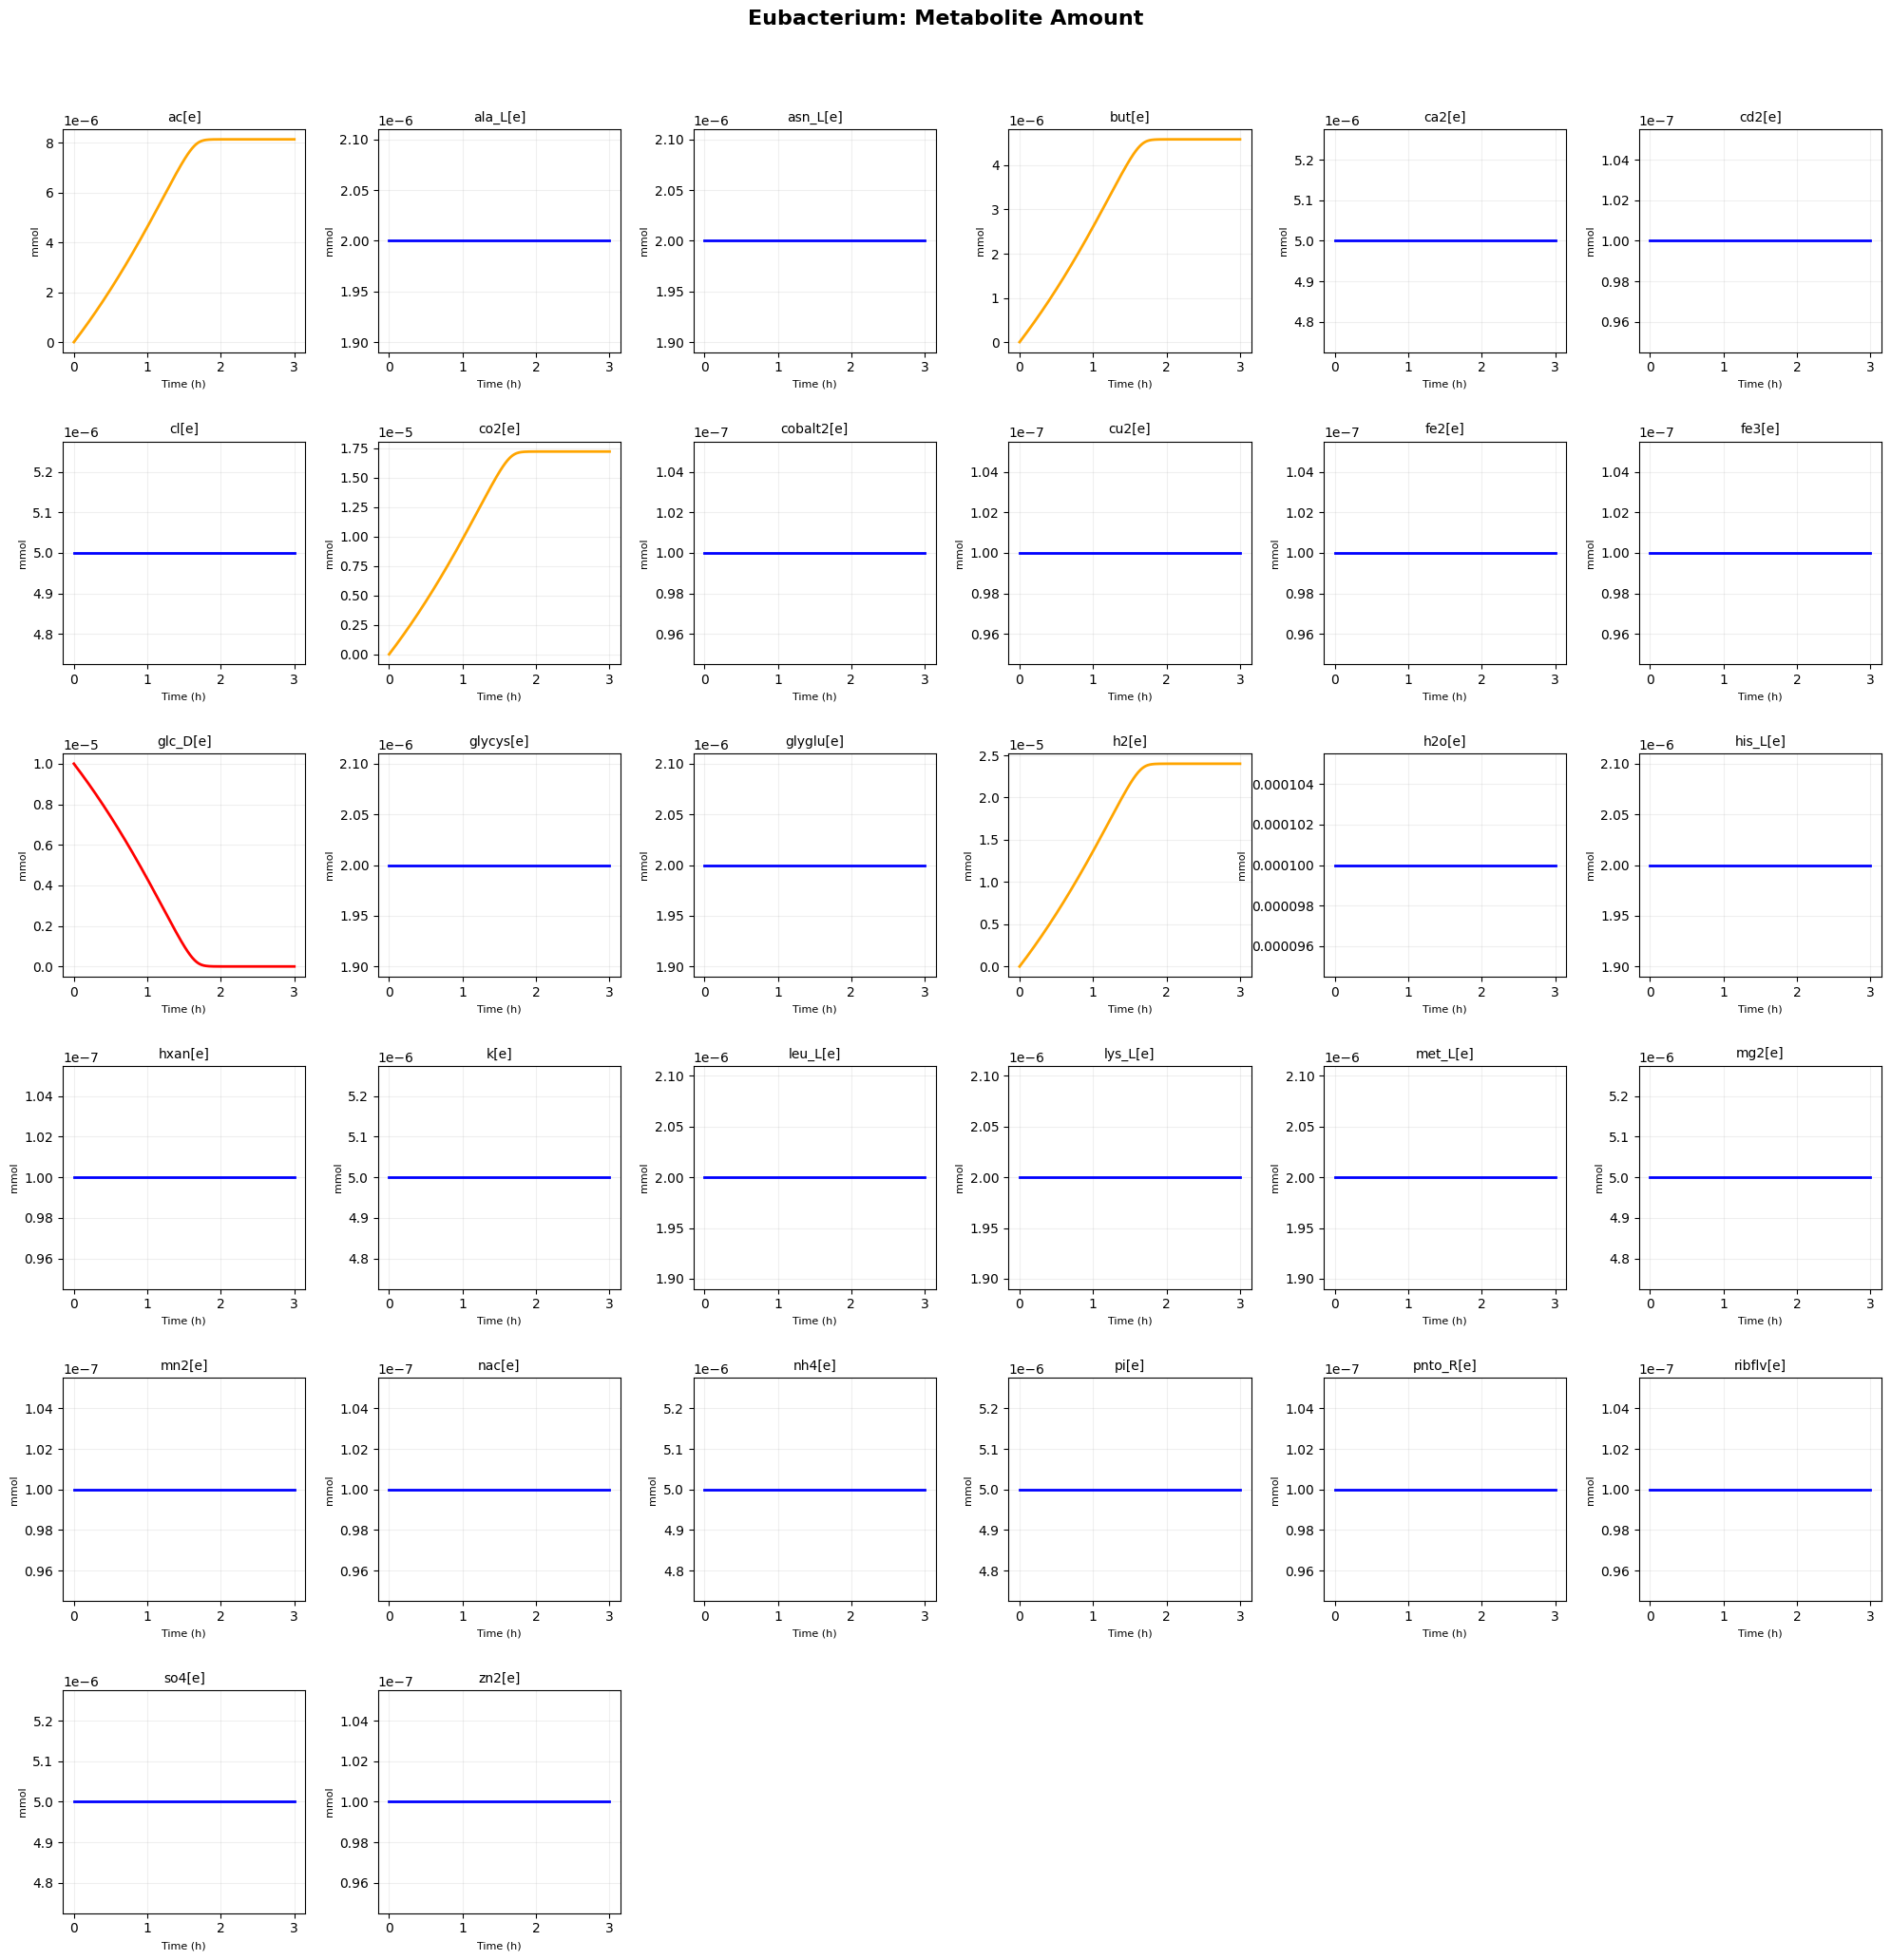

In [18]:
# metabolite concentrations 
media_piv2 = sim_eub.media.pivot(index='cycle', columns='metabolite', values='conc_mmol')
media_piv2.fillna(0, inplace=True)
conc_df2 = media_piv2.copy()

selected_mets2 = sorted([m for m in conc_df2.columns if 'biomass' not in m.lower()])

cols = 6
rows2 = math.ceil(len(selected_mets2) / cols)
fig5 = plt.figure(figsize=(20, 3.5 * rows2))
fig5.suptitle('Eubacterium: Metabolite Amount',
              fontsize=16, fontweight='bold', y=0.98)

time_c2 = conc_df2.index * TIME_STEP
for i, met in enumerate(selected_mets2):
    ax = fig5.add_subplot(rows2, cols, i + 1)
    conc = conc_df2[met]
    if len(conc) > 0 and conc.iloc[0] > 0 and conc.iloc[-1] < conc.iloc[0] * 0.01:
        lc = 'red'
    elif len(conc) > 0 and conc.iloc[0] == 0 and conc.iloc[-1] > 0:
        lc = 'orange'
    else:
        lc = 'blue'
    ax.plot(time_c2, conc, color=lc, linewidth=2)
    ax.set_xlabel('Time (h)', fontsize=8)
    ax.set_ylabel('mmol', fontsize=8)
    ax.set_title(met, fontsize=10)
    ax.grid(alpha=0.2)

plt.tight_layout(rect=[0, 0, 1, 0.96])
fig5.subplots_adjust(top=0.92, hspace=0.4, wspace=0.3)
plt.show()

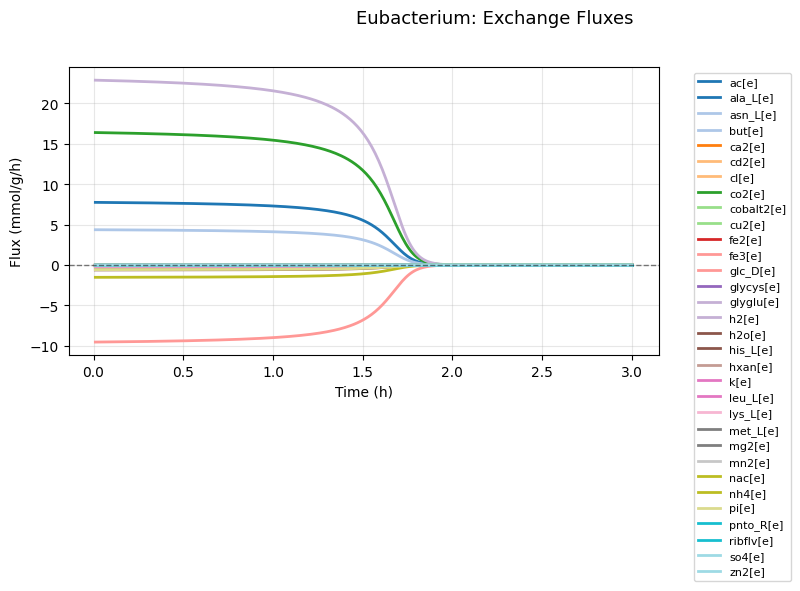

In [24]:
#Exchange flux 
selected_flux_mets2 = [m for m in selected_mets2 if m in media_piv2.columns]

fig6, ax = plt.subplots(figsize=(10, 5))
fig6.suptitle('Eubacterium: Exchange Fluxes',
              fontsize=13, y=0.98)

time_f2 = sim_eub.fluxes.iloc[:, 0] * TIME_STEP
colors2 = plt.cm.tab20(np.linspace(0, 1, len(selected_flux_mets2)))

for i, met in enumerate(sorted(selected_flux_mets2)):
    rxn_id = 'EX_' + met.replace('[e]', '(e)')
    idx = comets_eub.reactions[comets_eub.reactions['REACTION_NAMES'] == rxn_id].index
    if len(idx) == 0:
        continue
    col = 4 + idx[0]
    if col < sim_eub.fluxes.shape[1]:
        ax.plot(time_f2, sim_eub.fluxes.iloc[:, col], color=colors2[i], lw=2, label=met)

ax.axhline(y=0, color='k', ls='--', lw=1, alpha=0.5)
ax.set_xlabel('Time (h)'); ax.set_ylabel('Flux (mmol/g/h)')
ax.grid(alpha=0.3)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, ncol=1)
plt.tight_layout(rect=[0, 0, 0.82, 0.96])
plt.show()

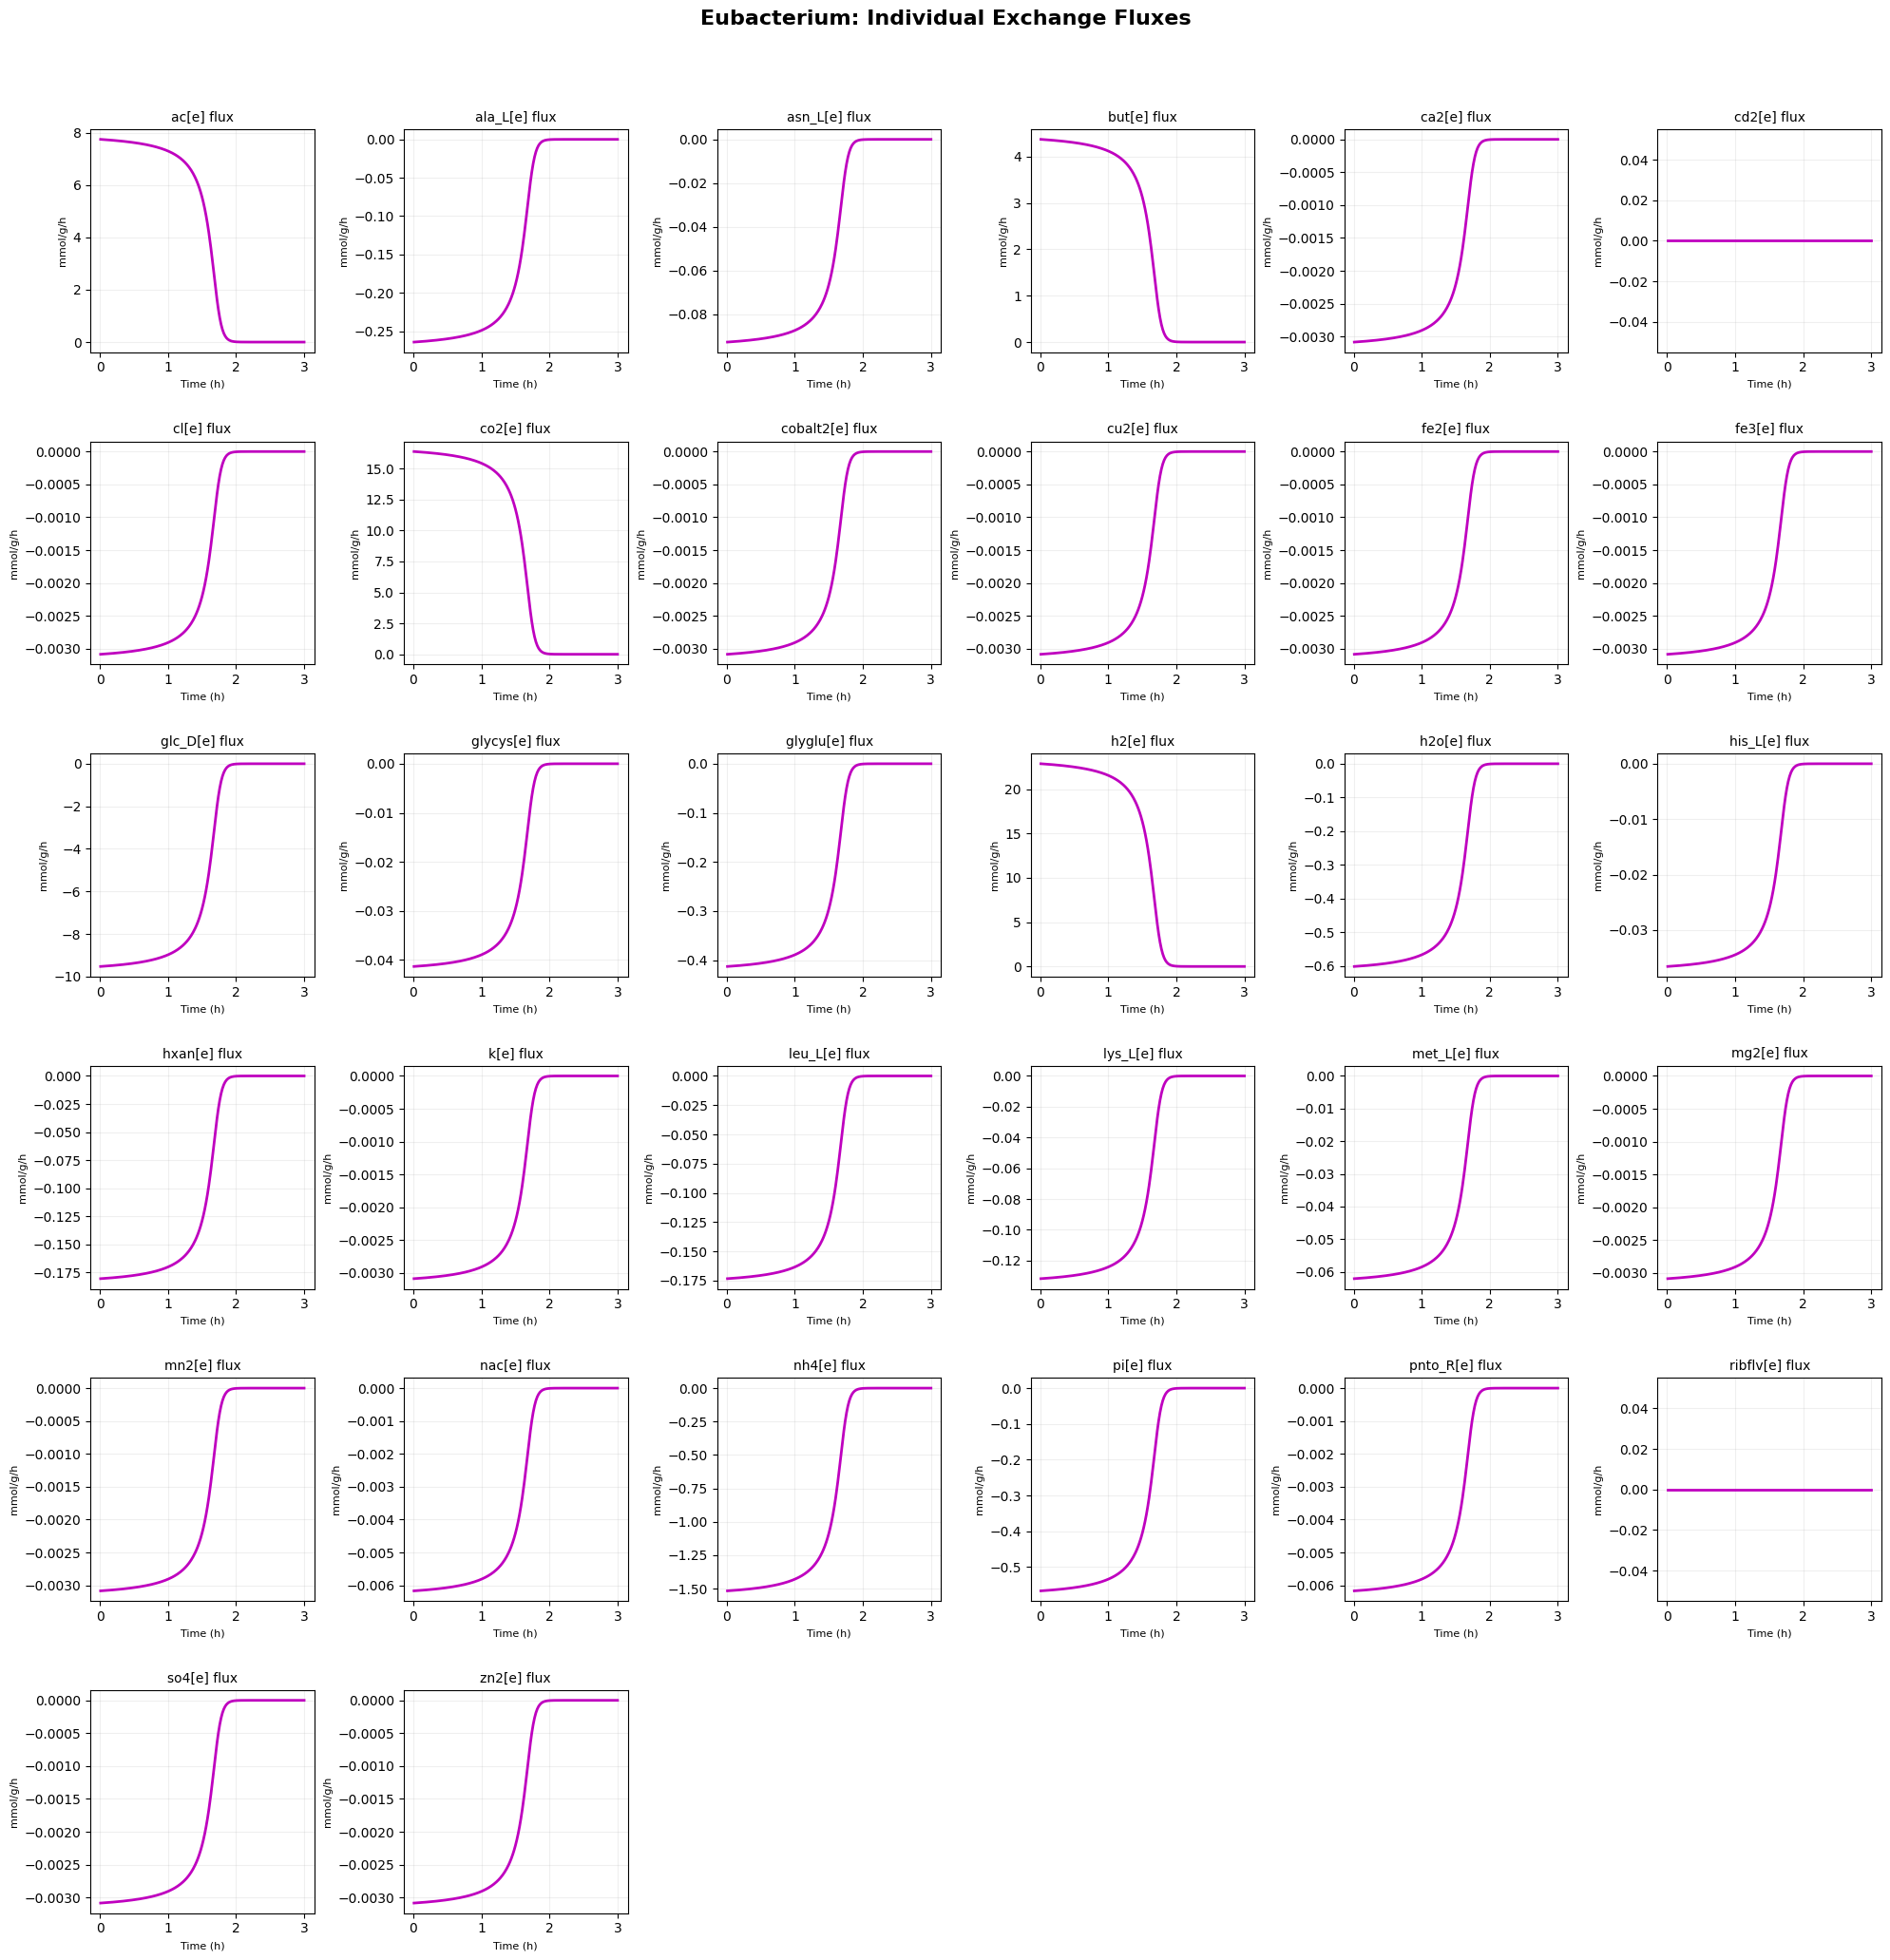

In [26]:
#Individual flux panels 
num_f2 = len(selected_flux_mets2)
rows_f2 = math.ceil(num_f2 / cols)
fig7 = plt.figure(figsize=(20, 3.5 * rows_f2))
fig7.suptitle('Eubacterium: Individual Exchange Fluxes', fontsize=16, fontweight='bold', y=0.98)

for i, met in enumerate(sorted(selected_flux_mets2)):
    rxn_id = 'EX_' + met.replace('[e]', '(e)')
    idx = comets_eub.reactions[comets_eub.reactions['REACTION_NAMES'] == rxn_id].index
    if len(idx) == 0:
        continue
    col_idx = 4 + idx[0]
    if col_idx >= sim_eub.fluxes.shape[1]:
        continue
    ax = fig7.add_subplot(rows_f2, cols, i + 1)
    ax.plot(time_f2, sim_eub.fluxes.iloc[:, col_idx], 'm', lw=2)
    ax.set_title(met + ' flux', fontsize=10)
    ax.set_xlabel('Time (h)', fontsize=8)
    ax.set_ylabel('mmol/g/h', fontsize=8)
    ax.grid(alpha=0.2)

plt.tight_layout(rect=[0, 0, 1, 0.96])
fig7.subplots_adjust(top=0.92, hspace=0.4, wspace=0.4)
plt.show()


Does Lactate Enhance Butyrate Production by *Eubacterium*?

Three conditions:

| Condition | Glucose | Lactate | Total carbon |
|-----------|---------|---------|-------------|
| Glucose Only | 10 mM | — | 60 mM C |
| Glucose + Lactate (total C fixed) | 5 mM | 10 mM | 60 mM C |
| Glucose + Lactate (individual substrates fixed) | 10 mM | 20 mM | 120 mM C |

In [27]:
# Load model
model_eub3 = cb.io.load_matlab_model('Eubacterium_hallii_DSM_3353.mat')
for rxn in model_eub3.exchanges:
    rxn.lower_bound = 0.0
    rxn.upper_bound = 1000.0

met_to_ex3 = {met.id: rxn.id for rxn in model_eub3.exchanges
              for met in rxn.metabolites if met.compartment == 'e'}
all_ex_mets3 = set(met_to_ex3.keys())

# conditions
conditions = {
    'Glucose Only': {
        'glc_D[e]': 10.0,
    },
    'Glucose + Lactate (total C fixed)': {
        'glc_D[e]': 5.0,
        'lac_L[e]': 10.0,
    },
    'Glucose + Lactate (substrates fixed)': {
        'glc_D[e]': 10.0,
        'lac_L[e]': 20.0,
    },
}


def run_condition(carbon_sources, condition_name):
    print(f'\n  {condition_name}: {carbon_sources}')

    model_copy = model_eub3.copy()
    model_copy.id = 'Eubacterium'
    cm = c.model(model_copy)
    cm.open_exchanges()
    clean_non_ex(cm)
    cm.initial_pop = [0, 0, INIT_BIOMASS]

    ly = c.layout([cm])
    ly.grid = [1, 1]
    classify_and_set_media(ly, all_ex_mets3)

    # Set carbon sources
    for met_id, conc_mM in carbon_sources.items():
        ly.set_specific_metabolite(met_id, mM_to_mmol(conc_mM))
        ly.set_specific_refresh(met_id, 0.0)

    p = make_params()
    sim = c.comets(ly, p)
    sim.run()
    return sim


print('RUNNING ALL CONDITIONS\n')
simulations = {}
for name, csources in conditions.items():
    simulations[name] = run_condition(csources, name)
print('\nAll done.')

No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


RUNNING ALL CONDITIONS


  Glucose Only: {'glc_D[e]': 10.0}

Running COMETS simulation ...

Debug Here ...
Done!

  Glucose + Lactate (total C fixed): {'glc_D[e]': 5.0, 'lac_L[e]': 10.0}

Running COMETS simulation ...

Debug Here ...
Done!

  Glucose + Lactate (substrates fixed): {'glc_D[e]': 10.0, 'lac_L[e]': 20.0}

Running COMETS simulation ...

Debug Here ...
Done!

All done.


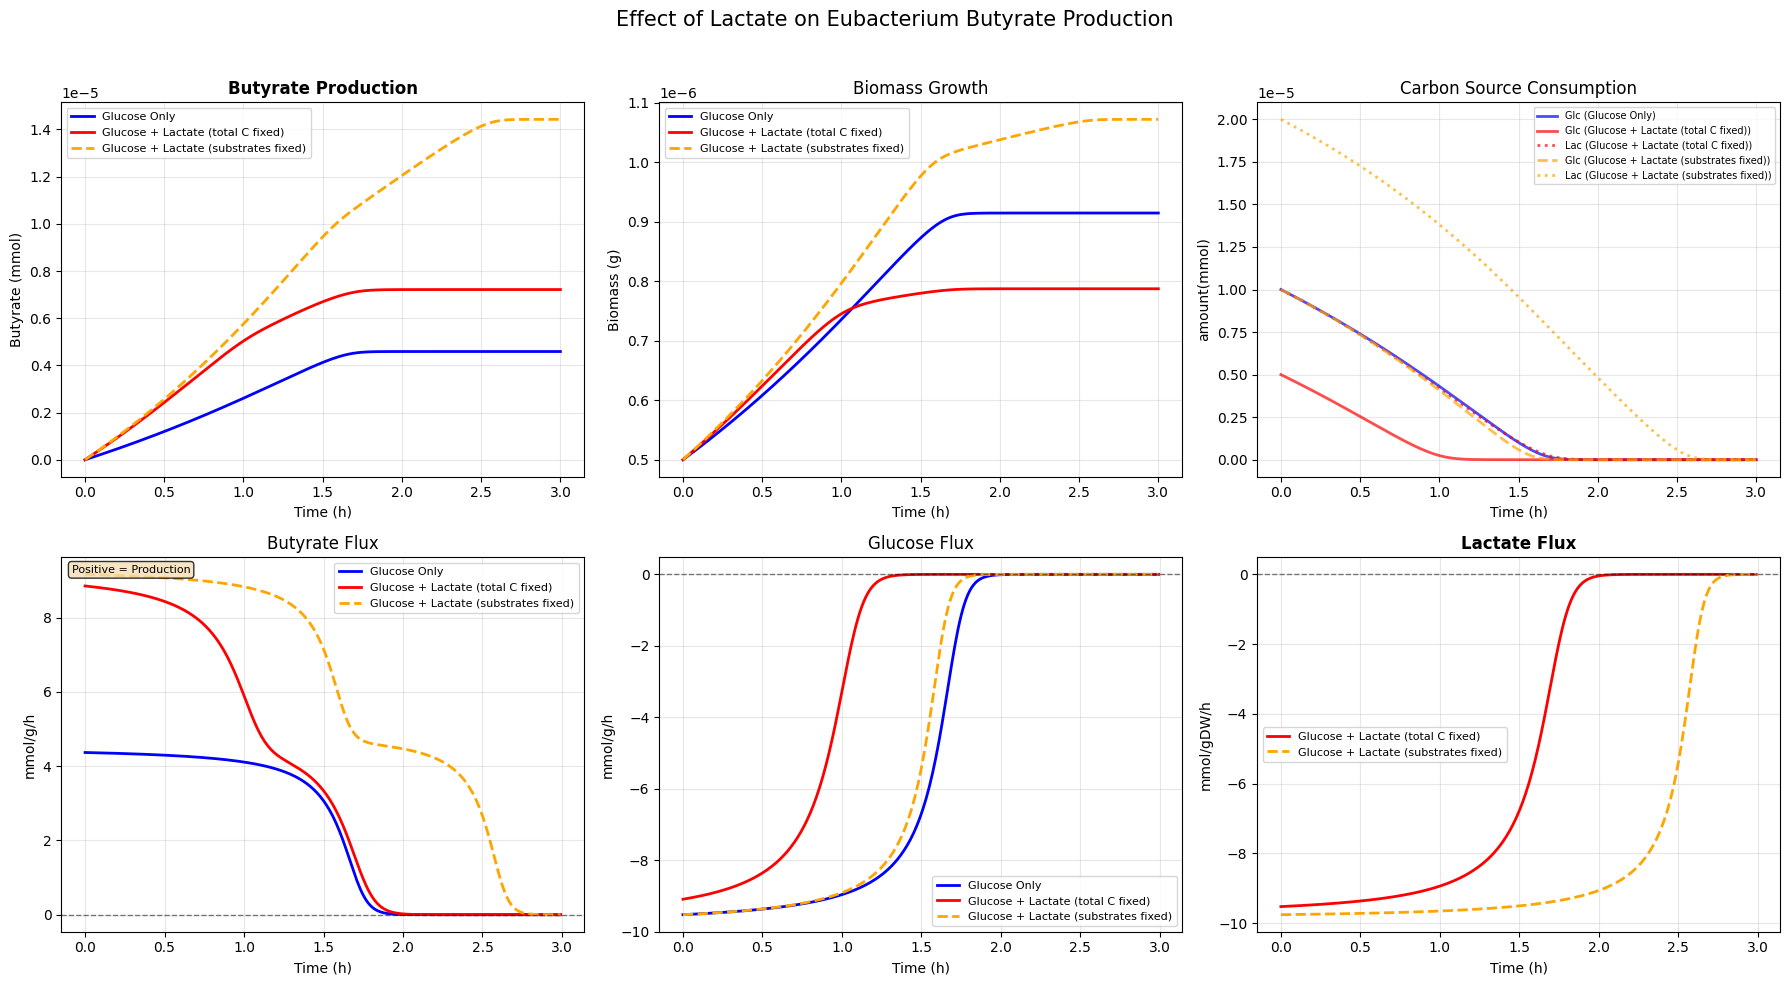

In [29]:
# data
def get_met_data(sim, metabolite):
    ts = sim.get_metabolite_time_series()
    if metabolite in ts.columns:
        return ts[metabolite].values
    return np.zeros(len(sim.total_biomass))

def get_flux_data(sim, metabolite, model_name='Eubacterium'):
    flux_df = sim.get_species_exchange_fluxes(model_name, threshold=1e-8)
    flux_col = 'EX_' + metabolite.replace('[e]', '(e)')
    if flux_col in flux_df.columns:
        return flux_df[flux_col].values
    return np.array([])


plot_colors = ['blue', 'red', 'orange']
plot_ls     = ['-', '-', '--']
data = {}

for i, (cname, sim) in enumerate(simulations.items()):
    time = np.arange(len(sim.total_biomass)) * TIME_STEP
    data[cname] = {
        'time':     time,
        'biomass':  sim.total_biomass['Eubacterium'].values,
        'butyrate': get_met_data(sim, 'but[e]') ,
        'glucose':  get_met_data(sim, 'glc_D[e]') ,
        'lactate':  get_met_data(sim, 'lac_L[e]'),
        'but_flux': get_flux_data(sim, 'but[e]'),
        'glc_flux': get_flux_data(sim, 'glc_D[e]'),
        'lac_flux': get_flux_data(sim, 'lac_L[e]'),
        'color': plot_colors[i],
        'ls':    plot_ls[i],
    }

# figure
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Effect of Lactate on Eubacterium Butyrate Production',
             fontsize=15, y=0.98)

# Row 1: Concentrations
ax = axes[0, 0]
for cn, d in data.items():
    ax.plot(d['time'], d['butyrate'], color=d['color'], ls=d['ls'], lw=2, label=cn)
ax.set_xlabel('Time (h)'); ax.set_ylabel('Butyrate (mmol)')
ax.set_title('Butyrate Production', fontweight='bold'); ax.legend(fontsize=8); ax.grid(alpha=0.3)

ax = axes[0, 1]
for cn, d in data.items():
    ax.plot(d['time'], d['biomass'], color=d['color'], ls=d['ls'], lw=2, label=cn)
ax.set_xlabel('Time (h)'); ax.set_ylabel('Biomass (g)')
ax.set_title('Biomass Growth'); ax.legend(fontsize=8); ax.grid(alpha=0.3)

ax = axes[0, 2]
for cn, d in data.items():
    ax.plot(d['time'], d['glucose'], color=d['color'], ls=d['ls'], lw=2,
            label=f'Glc ({cn})', alpha=0.7)
    if 'Lactate' in cn:
        ax.plot(d['time'], d['lactate'], color=d['color'], ls=':', lw=2,
                label=f'Lac ({cn})', alpha=0.7)
ax.set_xlabel('Time (h)'); ax.set_ylabel('amount(mmol)')
ax.set_title('Carbon Source Consumption'); ax.legend(fontsize=7); ax.grid(alpha=0.3)

# Row 2: Fluxes
ax = axes[1, 0]
for cn, d in data.items():
    if len(d['but_flux']) > 0:
        tf = d['time'][:len(d['but_flux'])]
        ax.plot(tf, d['but_flux'], color=d['color'], ls=d['ls'], lw=2, label=cn)
ax.axhline(0, color='k', ls='--', lw=1, alpha=0.5)
ax.set_xlabel('Time (h)'); ax.set_ylabel('mmol/g/h')
ax.set_title('Butyrate Flux'); ax.legend(fontsize=8); ax.grid(alpha=0.3)
ax.text(0.02, 0.98, 'Positive = Production', transform=ax.transAxes,
        va='top', fontsize=8, bbox=dict(boxstyle='round', fc='wheat', alpha=0.8))

ax = axes[1, 1]
for cn, d in data.items():
    if len(d['glc_flux']) > 0:
        tf = d['time'][:len(d['glc_flux'])]
        ax.plot(tf, d['glc_flux'], color=d['color'], ls=d['ls'], lw=2, label=cn)
ax.axhline(0, color='k', ls='--', lw=1, alpha=0.5)
ax.set_xlabel('Time (h)'); ax.set_ylabel('mmol/g/h')
ax.set_title('Glucose Flux'); ax.legend(fontsize=8); ax.grid(alpha=0.3)

ax = axes[1, 2]
for cn, d in data.items():
    if 'Lactate' in cn and len(d['lac_flux']) > 0:
        tf = d['time'][:len(d['lac_flux'])]
        ax.plot(tf, d['lac_flux'], color=d['color'], ls=d['ls'], lw=2, label=cn)
ax.axhline(0, color='k', ls='--', lw=1, alpha=0.5)
ax.set_xlabel('Time (h)'); ax.set_ylabel('mmol/gDW/h')
ax.set_title('Lactate Flux', fontweight='bold'); ax.legend(fontsize=8); ax.grid(alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

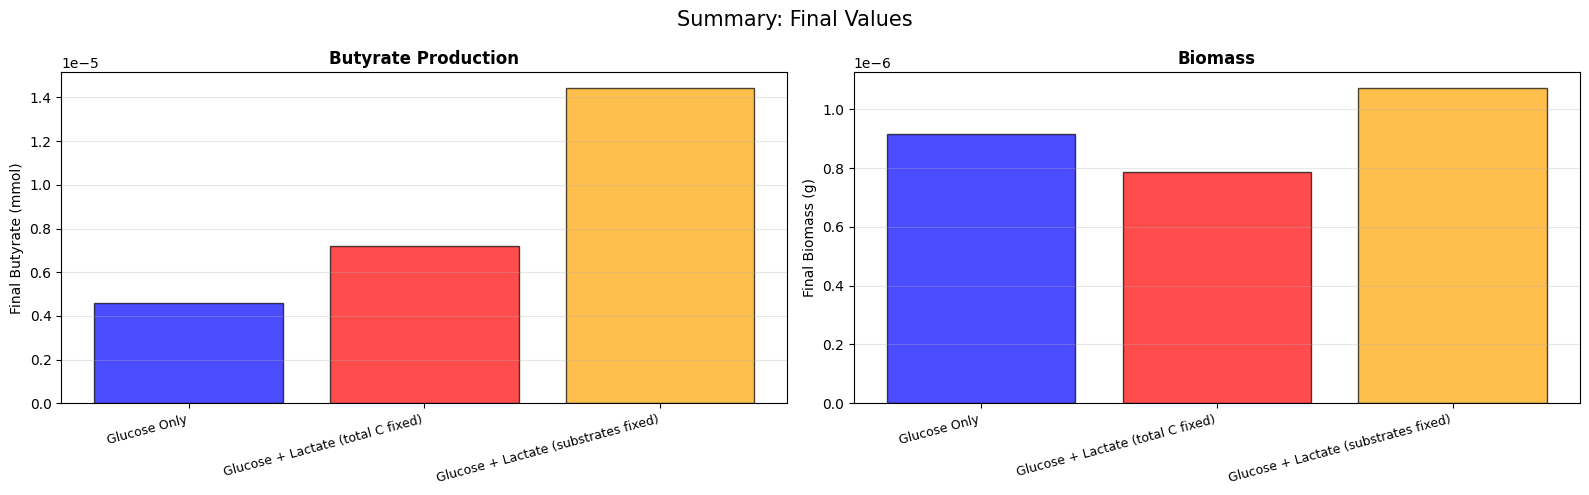

In [38]:
# Summary 
fig2, axes2 = plt.subplots(1, 2, figsize=(16, 5))
fig2.suptitle('Summary: Final Values', fontsize=15)

cnames = list(data.keys())
final_but = [d['butyrate'][-1] for d in data.values()]
final_bio = [d['biomass'][-1] for d in data.values()]
ccolors   = [d['color'] for d in data.values()]

ax = axes2[0]
bars = ax.bar(range(len(cnames)), final_but, color=ccolors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Final Butyrate (mmol)'); ax.set_title('Butyrate Production', fontweight='bold')
ax.set_xticks(range(len(cnames))); ax.set_xticklabels(cnames, rotation=15, ha='right', fontsize=9)
ax.grid(alpha=0.3, axis='y')

ax = axes2[1]
bars = ax.bar(range(len(cnames)), final_bio, color=ccolors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Final Biomass (g)'); ax.set_title('Biomass', fontweight='bold')
ax.set_xticks(range(len(cnames))); ax.set_xticklabels(cnames, rotation=15, ha='right', fontsize=9)
ax.grid(alpha=0.3, axis='y')


plt.tight_layout()
plt.show()